<a href="https://colab.research.google.com/github/tommasorigon/CompStat/blob/main/notebook/un_D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unit D2 - Approximate methods for probit and logit models


In this unit we discuss several approximate Bayesian methods that have been presented in the [**slides of unit D.2**](../slides/un_D2.pdf). We will make use of the Pima indian dataset again, as in the previous [**Markdown document B.1**](un_B1.html) and [**Markdown document B.2**](un_B2.html). Importantly, note that in this document we will **not standardize the predictors** to make the computational problem more challenging. 


## The Pima indian dataset


In [1]:
Pima <- rbind(MASS::Pima.tr, MASS::Pima.te)
y <- as.numeric(Pima$type == "Yes") # Binary outcome
X <- cbind(1, model.matrix(type ~ . - 1, data = Pima)) # Design matrix

We will employ a relatively vague prior centered at $0$, namely $\beta \sim N(0, 100 I_p)$. 



In [2]:
B <- diag(10, ncol(X)) # Prior covariance matrix
b <- rep(0, ncol(X)) # Prior mean

## The gold standard: MCMC

In order to assess the accuracy of the approximations, we first obtain a large number of posterior samples using the Pólya-gamma data augmentation approach. This is the same code that is reported also in the last paragraph of the [**Markdown document B.2**](un_B2.html).


In [4]:
install.packages("BayesLogit")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(BayesLogit)
logit_Gibbs <- function(R, burn_in, y, X, B, b) {
  p <- ncol(X)
  n <- nrow(X)
  out <- matrix(0, R, p) # Initialize an empty matrix to store the values

  P <- solve(B) # Prior precision matrix
  Pb <- P %*% b # Term appearing in the Gibbs sampling

  Xy <- crossprod(X, y - 1 / 2)

  # Initialization
  beta <- rep(0, p)

  # Iterative procedure
  for (r in 1:(R + burn_in)) {

    # Sampling the Pólya-gamma latent variables
    eta <- c(X %*% beta)
    omega <- rpg.devroye(num = n, h = 1, z = eta)

    # Sampling beta
    eig <- eigen(crossprod(X * sqrt(omega)) + P, symmetric = TRUE)

    Sigma <- crossprod(t(eig$vectors) / sqrt(eig$values))
    mu <- Sigma %*% (Xy + Pb)

    A1 <- t(eig$vectors) / sqrt(eig$values)
    beta <- mu + c(matrix(rnorm(1 * p), 1, p) %*% A1)

    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- beta
    }
  }
  out
}

In [6]:
set.seed(123)

# Running the MCMC
fit_MCMC <- logit_Gibbs(R = 10^5, burn_in = 5000, y, X, B, b) # MCMC (gold standard)

## Laplace approximation

The first approach considered is the Laplace approximation. Note that the MAP is obtained using the **Pólya-gamma data-augmentation**, therefore ensuring a monotonic procedure. Refer to the [**slides of unit D.2**](../slides/un_D2.pdf) for further details. 


In [8]:
logit_Laplace <- function(y, X, B, b, tol = 1e-16, maxiter = 10000) {
  P <- solve(B) # Prior precision matrix
  Pb <- P %*% b # Term appearing in the Gibbs sampling

  logpost <- numeric(maxiter)
  Xy <- crossprod(X, y - 0.5)

  # Initialization
  beta <- solve(crossprod(X / 4, X) + P, Xy + Pb)
  eta <- c(X %*% beta)
  w <- tanh(eta / 2) / (2 * eta)
  w[is.nan(w)] <- 0.25

  # First value of the likelihood
  logpost[1] <- sum(y * eta - log(1 + exp(eta))) - 0.5 * t(beta) %*% P %*% beta

  # Iterative procedure
  for (t in 2:maxiter) {
    beta <- solve(qr(crossprod(X * w, X) + P), Xy + Pb)
    eta <- c(X %*% beta)
    w <- tanh(eta / 2) / (2 * eta)
    w[is.nan(w)] <- 0.25

    logpost[t] <- sum(y * eta - log(1 + exp(eta))) - 0.5 * t(beta) %*% P %*% beta

    if (logpost[t] - logpost[t - 1] < tol) {
      prob <- plogis(eta)
      return(list(
        mu = c(beta), Sigma = solve(crossprod(X * prob * (1 - prob), X) + P),
        Convergence = cbind(Iteration = (1:t) - 1, logpost = logpost[1:t])
      ))
    }
  }
  stop("The algorithm has not reached convergence")
}

The marginal densities of the first two regression coefficients are reported, together with the "gold standard" obtained from the MCMC samples. 



In [9]:
install.packages("tictoc")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



0.055 sec elapsed


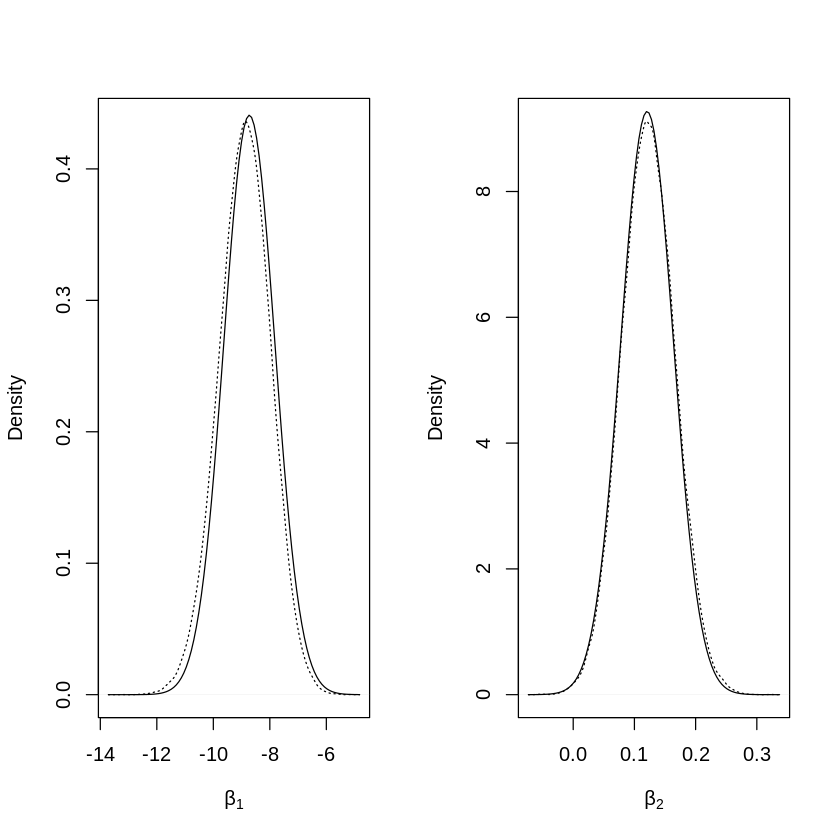

In [10]:
library(tictoc)

tic()
fit_Laplace <- logit_Laplace(y, X, B, b)
toc()

par(mfrow = c(1, 2))
plot(density(fit_MCMC[, 1]), xlab = expression(beta[1]), lty = "dotted", main = "")
curve(dnorm(x, fit_Laplace$mu[1], sqrt(fit_Laplace$Sigma[1, 1])), add = T)

plot(density(fit_MCMC[, 2]), xlab = expression(beta[2]), lty = "dotted", main = "")
curve(dnorm(x, fit_Laplace$mu[2], sqrt(fit_Laplace$Sigma[2, 2])), add = T)

## Variational Bayes

The second approximation is the Variational Bayes approximation of [**Jaakkola and Jordan (2000)**](https://link.springer.com/article/10.1023/A:1008932416310) and later considered also by [**Durante and Rigon (2019)**](https://projecteuclid.org/euclid.ss/1570780980). 


In [11]:
# Compute the log-determinant of a matrix
ldet <- function(X) {
  if (!is.matrix(X)) {
    return(log(X))
  }
  determinant(X, logarithm = TRUE)$modulus
}

logit_CAVI <- function(y, X, B, b, tol = 1e-16, maxiter = 10000) {
  lowerbound <- numeric(maxiter)
  p <- ncol(X)
  n <- nrow(X)

  P <- solve(B)
  Pb <- c(P %*% b)
  Pdet <- ldet(P)

  # Initialization for omega equal to 0.25
  P_vb <- crossprod(X * rep(1 / 4, n), X) + P
  Sigma_vb <- solve(P_vb)
  mu_vb <- Sigma_vb %*% (crossprod(X, y - 0.5) + Pb)
  eta <- c(X %*% mu_vb)
  xi <- sqrt(eta^2 + rowSums(X %*% Sigma_vb * X))
  omega <- tanh(xi / 2) / (2 * xi)
  omega[is.nan(omega)] <- 0.25

  lowerbound[1] <- 0.5 * p + 0.5 * ldet(Sigma_vb) + 0.5 * Pdet - 0.5 * t(mu_vb - b) %*% P %*% (mu_vb - b) + sum((y - 0.5) * eta + log(plogis(xi)) - 0.5 * xi) - 0.5 * sum(diag(P %*% Sigma_vb))

  # Iterative procedure
  for (t in 2:maxiter) {
    P_vb <- crossprod(X * omega, X) + P
    Sigma_vb <- solve(P_vb)
    mu_vb <- Sigma_vb %*% (crossprod(X, y - 0.5) + Pb)

    # Update of xi
    eta <- c(X %*% mu_vb)
    xi <- sqrt(eta^2 + rowSums(X %*% Sigma_vb * X))
    omega <- tanh(xi / 2) / (2 * xi)
    omega[is.nan(omega)] <- 0.25

    lowerbound[t] <- 0.5 * p + 0.5 * ldet(Sigma_vb) + 0.5 * Pdet - 0.5 * t(mu_vb - b) %*% P %*% (mu_vb - b) + sum((y - 0.5) * eta + log(plogis(xi)) - 0.5 * xi) - 0.5 * sum(diag(P %*% Sigma_vb))

    if (abs(lowerbound[t] - lowerbound[t - 1]) < tol) {
      return(list(
        mu = c(mu_vb), Sigma = matrix(Sigma_vb, p, p),
        Convergence = cbind(
          Iteration = (1:t) - 1,
          Lowerbound = lowerbound[1:t]
        ), xi = xi
      ))
    }
  }
  stop("The algorithm has not reached convergence")
}

The marginal densities of the first two regression coefficients are reported, together with the "gold standard" obtained from the MCMC samples. 



0.069 sec elapsed


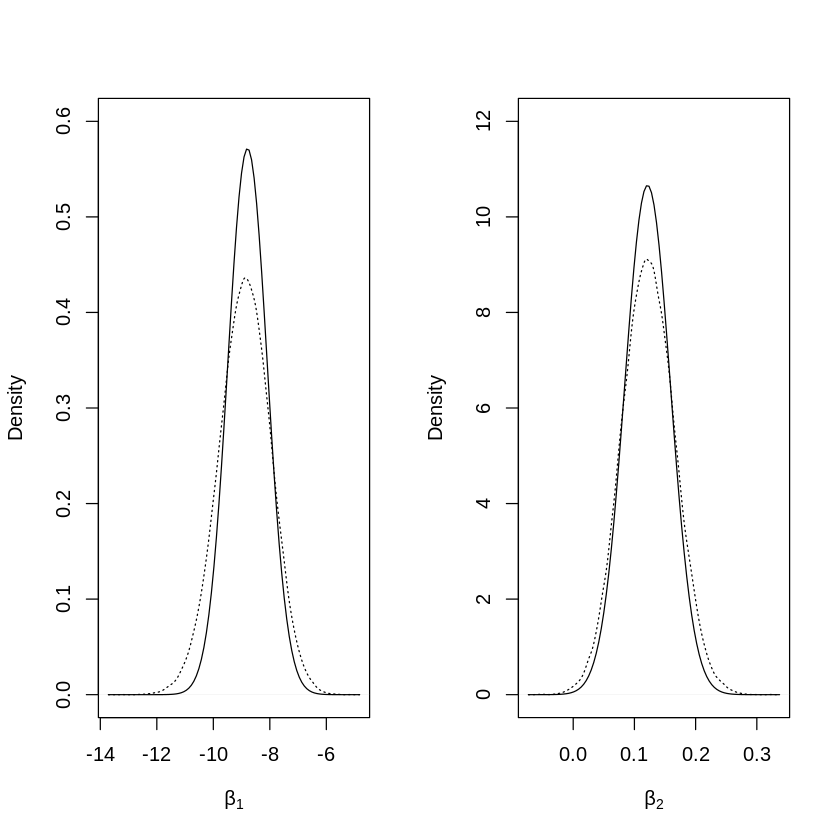

In [12]:
tic()
fit_CAVI <- logit_CAVI(y, X, B, b)
toc()

par(mfrow = c(1, 2))
plot(density(fit_MCMC[, 1]), xlab = expression(beta[1]), lty = "dotted", main = "", ylim = c(0, 0.6))
curve(dnorm(x, fit_CAVI$mu[1], sqrt(fit_CAVI$Sigma[1, 1])), add = T)

plot(density(fit_MCMC[, 2]), xlab = expression(beta[2]), lty = "dotted", main = "", ylim = c(0, 12))
curve(dnorm(x, fit_CAVI$mu[2], sqrt(fit_CAVI$Sigma[2, 2])), add = T)

## Expectation propagation

The third approximation is the expectation propagation, which is described in the logistic regression case for example by [**Chopin and Ridgway (2017)**](https://projecteuclid.org/journals/statistical-science/volume-32/issue-1/Leave-Pima-Indians-Alone--Binary-Regression-as-a-Benchmark/10.1214/16-STS581.full).

Note: the `EPGLM` package that compute the EP approximation using the `EPlogit` command  is not anymore available on the CRAN. However, the source code can be [**downloaded here**](https://cran.r-project.org/src/contrib/Archive/EPGLM/EPGLM_1.1.2.tar.gz) and installed manually.  

The marginal densities of the first two regression coefficients are reported, together with the "gold standard" obtained from the MCMC samples. 


In [ ]:
library(EPGLM)

tic()
fit_EP <- EPlogit(X, y, s = B[1, 1])
toc()

par(mfrow = c(1, 2))
plot(density(fit_MCMC[, 1]), xlab = expression(beta[1]), lty = "dotted", main = "")
curve(dnorm(x, fit_EP$m[1], sqrt(fit_EP$V[1, 1])), add = T)

plot(density(fit_MCMC[, 2]), xlab = expression(beta[2]), lty = "dotted", main = "")
curve(dnorm(x, fit_EP$m[2], sqrt(fit_EP$V[2, 2])), add = T)

## Hybrid Laplace

THe fourth approach is based on the variational Bayes approximation mean estimate which is plugged-in into the Fisher information matrix. This procedure is described in the [**slides of unit D.2**](../slides/un_D2.pdf). 


In [14]:
logit_HL <- function(y, X, B, b, tol = 1e-16, maxiter = 10000) {
  fit_HL <- logit_CAVI(y, X, B, b, tol, maxiter)
  prob <- c(plogis(X %*% fit_CAVI$mu))
  fit_HL$Sigma <- solve(crossprod(X * prob * (1 - prob), X) + solve(B))
  fit_HL
}

The marginal densities of the first two regression coefficients are reported, together with the "gold standard" obtained from the MCMC samples. 



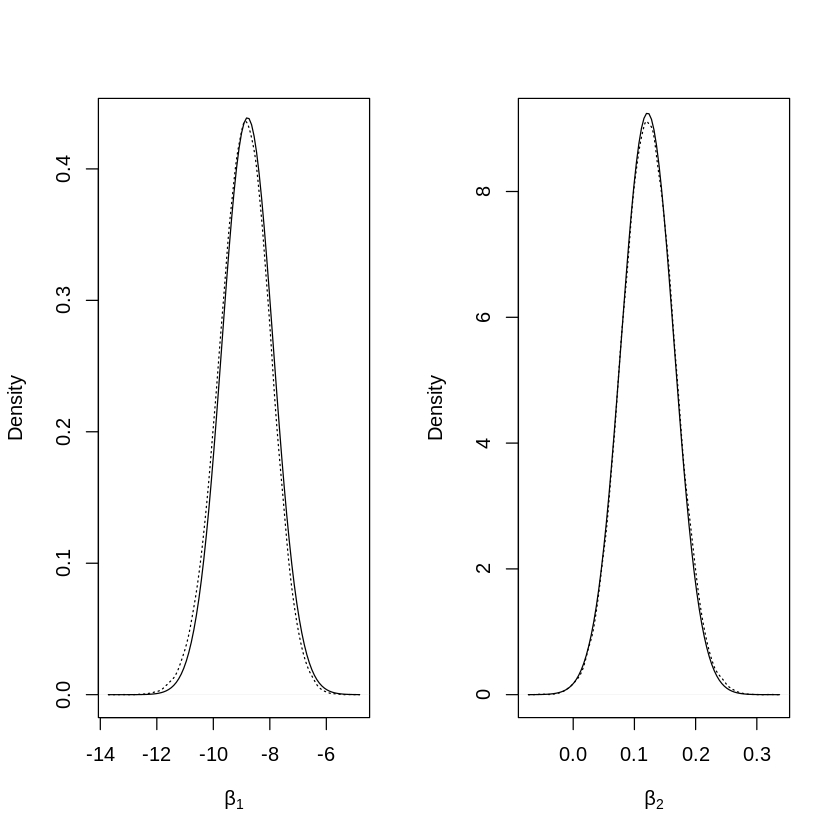

In [15]:
fit_HL <- logit_HL(y, X, B, b)

par(mfrow = c(1, 2))
plot(density(fit_MCMC[, 1]), xlab = expression(beta[1]), lty = "dotted", main = "")
curve(dnorm(x, fit_HL$mu[1], sqrt(fit_HL$Sigma[1, 1])), add = T)

plot(density(fit_MCMC[, 2]), xlab = expression(beta[2]), lty = "dotted", main = "")
curve(dnorm(x, fit_HL$mu[2], sqrt(fit_HL$Sigma[2, 2])), add = T)

## Further comparisons

In the following, we report the posterior means and variances under the all the previous approximations together with the gold standard MCMC values. 

### Mean and variances


In [ ]:
mu_MCMC <- colMeans(fit_MCMC)
Sigma_MCMC <- var(fit_MCMC)

Means <- data.frame(
  MCMC = mu_MCMC,
  Laplace = fit_Laplace$mu,
  VB = fit_CAVI$mu,
  EP = fit_EP$m,
  HL = fit_HL$mu
)
knitr::kable(Means, digits = 4)

In [ ]:
Sd <- data.frame(
  MCMC = sqrt(diag(var(fit_MCMC))),
  Laplace = sqrt(diag(fit_Laplace$Sigma)),
  VB = sqrt(diag(fit_CAVI$Sigma)),
  EP = sqrt(diag(fit_EP$V)),
  HL = sqrt(diag(fit_HL$Sigma))
)
knitr::kable(Sd, digits = 4, row.names = F)


### Discrepancy from the optimal Gaussian

In the last table, we comput the Kullback-Leibler divergence between the obtained Gaussian approximations and the "optimal" Gaussian distribution, which is the one matching the correct posterior mean and variance. These quantities are approximated using MCMC. 


In [18]:
install.packages("expm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [19]:
KL_gauss <- function(mu1, Sigma1, mu2, Sigma2) {
  p <- ncol(Sigma1)
  c(0.5 * (ldet(Sigma2) - ldet(Sigma1) - p + sum(diag(solve(Sigma2) %*% Sigma1)) + t(mu2 - mu1) %*% solve(Sigma2) %*% (mu2 - mu1)))
}

library(expm)
dWass_gauss <- function(mu1, Sigma1, mu2, Sigma2) {
  Sigma2_r <- sqrtm(Sigma2)
  c(crossprod(mu2 - mu1) + sum(diag(Sigma1 + Sigma2 - 2 * sqrtm(Sigma2_r %*% Sigma1 %*% Sigma2_r))))
}

Loading required package: Matrix


Attaching package: ‘expm’


The following object is masked from ‘package:Matrix’:

    expm




In [21]:
tab <- data.frame(
  Type = c("Laplace", "Variational Bayes",  "Hybrid Laplace"),
  KL = c(
    KL_gauss(fit_Laplace$mu, fit_Laplace$Sigma, mu_MCMC, Sigma_MCMC),
    KL_gauss(fit_CAVI$mu, fit_CAVI$Sigma, mu_MCMC, Sigma_MCMC),
#    KL_gauss(fit_EP$m, fit_EP$V, mu_MCMC, Sigma_MCMC),
    KL_gauss(fit_HL$mu, fit_HL$Sigma, mu_MCMC, Sigma_MCMC)
  ),
  Wasserstein = c(
    dWass_gauss(mu_MCMC, Sigma_MCMC, fit_Laplace$mu, fit_Laplace$Sigma),
    dWass_gauss(mu_MCMC, Sigma_MCMC, fit_CAVI$mu, fit_CAVI$Sigma),
 #   dWass_gauss(mu_MCMC, Sigma_MCMC, fit_EP$m, fit_EP$V),
    dWass_gauss(mu_MCMC, Sigma_MCMC, fit_HL$mu, fit_HL$Sigma)
  )
)
knitr::kable(tab, digits = 4)



|Type              |     KL| Wasserstein|
|:-----------------|------:|-----------:|
|Laplace           | 0.0296|      0.0294|
|Variational Bayes | 0.2742|      0.0652|
|Hybrid Laplace    | 0.0113|      0.0112|